# Analyzing Sentiment Trends with Twitter Data

## Introduction

This notebook will focus on analyzing the text data pulled with Twint. It contains the following:

* Sentiment tagging with Textblob
* Text cleaning, processing, and examination
* Topic modeling based on sentiment

Due to the nature of Twitter/Twint, lots of cleaning is needed to remove things like URLs and special characters to get the most meaning from the data. Some data cleaning is done before sentiment matching, i.e. removing URLs/twitter handles so that they don't affect the polarity score. However most is done after sentiment tagging to tokenize the data for clustering.

In [148]:
import pandas as pd
from textblob import TextBlob
pd.set_option('display.max_colwidth', -1)
import matplotlib.pyplot as plt

#NLP
import re
import nltk
import string
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

#pulling in py file that maps contractions to full words
from contractions import CONTRACTION_MAP

#topic modeling
import gensim
import gensim.corpora as corpora
import pyLDAvis.gensim
import pickle 
import pyLDAvis
from pprint import pprint

In [149]:
df = pd.read_csv('data/twint_scraped_clean.csv',  usecols=['date', 'tweet', 'geo'])

In [150]:
#remove data from 12.31 that pulled in
df = df[df['date'] >= '2021-01-01'] 

I've read in the data pulled with Twint. Now I'm going to use regex to remove a lot of the stuff in the tweets that I don't want to factor into my analysis, such as links, symbols, and @handles. 

## Cleaning Text with Regex

The Regex package will help me get non-informative text out of my data by writing patterns to recognize URLs and handles, and using substitution to remove them. I want to do this before assigning a sentiment score in case it throws anything off.

In [151]:
#creating a new clean column to remove URLs and @ mentions
df['clean_text'] = df['tweet']

#first, replacing some of the weird characters that twint is pulling in
df['clean_text'] = df['clean_text'].str.replace("â€", "'")
df['clean_text'] = df['clean_text'].str.replace("�", "")
df['clean_text'] = df['clean_text'].str.replace("™", "'")

#removing links
df['clean_text'] = [re.sub(r'(http://[^"\s]+)|(@\w+)', '', tweet) for tweet in df['clean_text']]
df['clean_text'] = [re.sub(r'(https://[^"\s]+)|(@\w+)', '', tweet) for tweet in df['clean_text']]

#removing handles
df['clean_text'] = [re.sub(r'@[^\s]+', '', tweet) for tweet in df['clean_text']]

#removing hashtag symbols but keeping the words
df['clean_text'] = [re.sub(r"#", "", tweet) for tweet in df['clean_text']]


Much better, I can now focus on the content of the text.

In [152]:
df.head()

,date,tweet,geo,clean_text
0,2021-06-13,"@CFetzRun @DioAlexandro2 @deathforeskin @ALV550 @jonmchu It was definitely required in every public location (library, DMV, etc). Also in most private locations (grocery stores, etc). Other countries are suffering too, lol. Not just US. Japan is still in a state of emergency. Canada has barely any vaccines. The virus canâ€™t be stopped.",chicago,"It was definitely required in every public location (library, DMV, etc). Also in most private locations (grocery stores, etc). Other countries are suffering too, lol. Not just US. Japan is still in a state of emergency. Canada has barely any vaccines. The virus can''t be stopped."
1,2021-06-13,"Went to the park where a guitar-bass-drum jazz trio plays every Sunday and I GOT TO SEE MORE FRIENDS, INCLUDING SOME TWO DAYS IN A ROW. A vaccine and a summer are some pretty wonderful things",chicago,"Went to the park where a guitar-bass-drum jazz trio plays every Sunday and I GOT TO SEE MORE FRIENDS, INCLUDING SOME TWO DAYS IN A ROW. A vaccine and a summer are some pretty wonderful things"
2,2021-06-13,Covid cases fall across US but experts warn of dangers of vaccine hesitancy - The Guardian https://t.co/dcocHClLVd,chicago,Covid cases fall across US but experts warn of dangers of vaccine hesitancy - The Guardian
3,2021-06-13,Sogard avoided that tag at second like it was the COVID vaccine,chicago,Sogard avoided that tag at second like it was the COVID vaccine
4,2021-06-13,"@TheEliKlein @RyanKemper10 I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didnâ€™t pretend adverse effects donâ€™t exist.",chicago,"I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didn''t pretend adverse effects don''t exist."


## Assinging a Sentiment with Textblob

I'm using the Textblob library which can run a polarity score to analyze the text content to determine how negative or positive it is on a scale of -1 (most negative) to 1 (most positive). While this capability isn't perfect, it can do a great job of assigning sentiment across large datasets quickly.

After creating a function to score the text, I am adding a column to display the score and another column to classify that score based on Textblob's guidelines.

In [153]:
def get_polarity(text):
    
    """ 
    assign tweet a polarity score between -1, 1
    """
    
    return TextBlob(text).sentiment.polarity

In [154]:
# new column to display scores
df['tb_polarity'] = df['clean_text'].apply(get_polarity)

In [155]:
# new column to label sentiment based on score
df['tb_sentiment'] = ''
df.loc[df.tb_polarity > 0, 'tb_sentiment'] = 'positive'
df.loc[df.tb_polarity == 0, 'tb_sentiment'] = 'neutral'
df.loc[df.tb_polarity < 0, 'tb_sentiment'] = 'negative'

While this method is effective, I can see from a preview that it does have a hard time recognizing negativity, which will be an important caveat for analysis. 

In [156]:
df.head()

,date,tweet,geo,clean_text,tb_polarity,tb_sentiment
0,2021-06-13,"@CFetzRun @DioAlexandro2 @deathforeskin @ALV550 @jonmchu It was definitely required in every public location (library, DMV, etc). Also in most private locations (grocery stores, etc). Other countries are suffering too, lol. Not just US. Japan is still in a state of emergency. Canada has barely any vaccines. The virus canâ€™t be stopped.",chicago,"It was definitely required in every public location (library, DMV, etc). Also in most private locations (grocery stores, etc). Other countries are suffering too, lol. Not just US. Japan is still in a state of emergency. Canada has barely any vaccines. The virus can''t be stopped.",0.175000,positive
1,2021-06-13,"Went to the park where a guitar-bass-drum jazz trio plays every Sunday and I GOT TO SEE MORE FRIENDS, INCLUDING SOME TWO DAYS IN A ROW. A vaccine and a summer are some pretty wonderful things",chicago,"Went to the park where a guitar-bass-drum jazz trio plays every Sunday and I GOT TO SEE MORE FRIENDS, INCLUDING SOME TWO DAYS IN A ROW. A vaccine and a summer are some pretty wonderful things",0.583333,positive
2,2021-06-13,Covid cases fall across US but experts warn of dangers of vaccine hesitancy - The Guardian https://t.co/dcocHClLVd,chicago,Covid cases fall across US but experts warn of dangers of vaccine hesitancy - The Guardian,0.000000,neutral
3,2021-06-13,Sogard avoided that tag at second like it was the COVID vaccine,chicago,Sogard avoided that tag at second like it was the COVID vaccine,0.000000,neutral
4,2021-06-13,"@TheEliKlein @RyanKemper10 I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didnâ€™t pretend adverse effects donâ€™t exist.",chicago,"I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didn''t pretend adverse effects don''t exist.",0.053333,positive


## Text Processing & Exploration

Now that all my data is labeled, I'm going to look into some trends. 

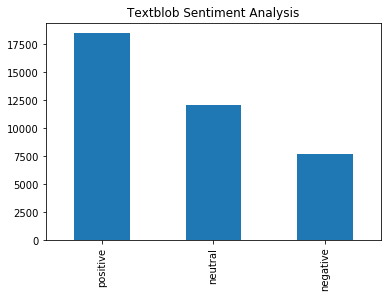

In [157]:
df.tb_sentiment.value_counts().plot(kind='bar',title="Textblob Sentiment Analysis")

Overall, sentiment is mostly positive, which is consistent with the preview above. I'll need to factor in that Textblob is not necessarily 100% accurate, and many times interpretation can be subjective, especially when the tweet itself is negative but the overall opinion toward vaccines is conveyed as positive. 

To look deeper into positive vs negative, I'm going to show the most frequent words and visualize with a word cloud. This will require further text cleaning to make sure I'm getting the most relevant results. I'll start by separating positive, negative, and neutral data into separate dataframes.

In [158]:
negatives = df[df['tb_sentiment'] == 'negative'].reset_index()
positives = df[df['tb_sentiment'] == 'positive'].reset_index()
neutral = df[df['tb_sentiment'] == 'neutral'].reset_index()

When I first ran the text analysis I saw that contractions were being split and strings like "n't" were showing up as frequent words. To solve this I am using a py file and function imported from [this repository](https://github.com/dipanjanS/practical-machine-learning-with-python) in order to map contractions to full words. After defining the fuction and applying it across all the text data, I can see the results in the example below.

In [159]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    """
    Using the contractions.py file cloned to this repository, 
    defines a regex pattern and uses it to map contractions to
    full words and replace them in the text.
    """
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


In [160]:
positives['clean_text'] = list(map(expand_contractions, positives['clean_text']))
negatives['clean_text'] = list(map(expand_contractions, negatives['clean_text']))
neutral['clean_text'] = list(map(expand_contractions, neutral['clean_text']))

In [161]:
positives['clean_text'][2] #shows expanded contraction example

'  I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didnt pretend adverse effects dont exist.'

Then I am using NLTK's stopwords list to remove words that don't add meaning (i.e. 'is', 'who', 'for') and adding punctuation, as well as the term 'vaccine' as this should be in every tweet. I can see that Twint is also pulling in some things as weird characters so I'm adding those to my punctuation list so they'll be removed.

In [162]:
stopwords_list = stopwords.words('english')
stopwords_list += string.punctuation
punct_list = ["''", '""', '...', '``', 'amp', "'", '"', "`", "â€™", "â€",
              'ðÿ', '’', '¯', 'ðÿ™', 'â€˜', 'â€�', 'â€œ', 'ðÿ˜', '�ðÿ', '‘', '�']
stopwords_list += punct_list
stopwords_list.extend(['vaccine', 'vaccines'])

Then I'm going to incorporate this into a tokenize function that will tokenize the data, lowercase words, and remove stopwords and symbols all at once.

In [163]:
def tokenize(tweet):
    """
    Preps text data for processing by passing
    several data cleaning techniques at once:
    mapping contractions, lowercasing, and 
    removing stopwords/punctuation
    """
    tokens = nltk.word_tokenize(tweet)
    words_lower = [word.lower() for word in tokens]
    words_stopped = [
        word for word in words_lower if word not in stopwords_list]

    return words_stopped

In [164]:
processed_data_positive = list(map(tokenize, positives['clean_text']))
processed_data_negative = list(map(tokenize, negatives['clean_text']))
processed_data_neutral = list(map(tokenize, neutral['clean_text']))
processed_data_positive[0]

['definitely',
 'required',
 'every',
 'public',
 'location',
 'library',
 'dmv',
 'etc',
 'also',
 'private',
 'locations',
 'grocery',
 'stores',
 'etc',
 'countries',
 'suffering',
 'lol',
 'us',
 'japan',
 'still',
 'state',
 'emergency',
 'canada',
 'barely',
 'virus',
 'cant',
 'stopped']

To get a visual of my positive vs negative data, I'm going to create word clouds. To make these, I'm compiling a frequency distribution of most common words in positive and negative labeled data and using the top 500 for the word cloud.

In [165]:
pos_tweet_concat = []
for tweet in processed_data_positive:
    pos_tweet_concat += tweet
    
pos_tweet_freqdist = FreqDist(pos_tweet_concat)

In [166]:
neg_tweet_concat = []
for tweet in processed_data_negative:
    neg_tweet_concat += tweet
    
neg_tweet_freqdist = FreqDist(neg_tweet_concat)

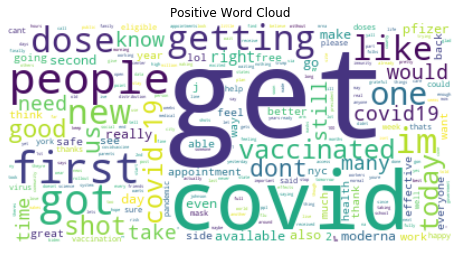

In [167]:
p_wc = WordCloud(background_color="white", max_words=500)
p_wc.generate_from_frequencies(pos_tweet_freqdist)

plt.figure(figsize=(8,8))
plt.imshow(p_wc, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.title('Positive Word Cloud')
plt.show()

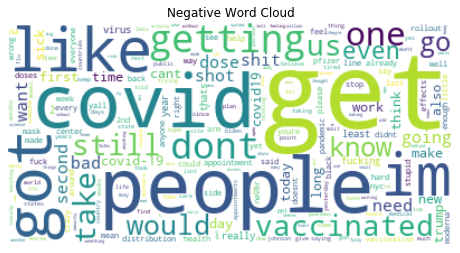

In [168]:
n_wc = WordCloud(background_color="white", max_words=500)
n_wc.generate_from_frequencies(neg_tweet_freqdist)

plt.figure(figsize=(8,8))
plt.imshow(n_wc, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.title('Negative Word Cloud')
plt.show()

The word clouds give some indication of what positive and negative sentiment revolves around: with the positive word cloud there are a lot of terms around availability (today, available, new, appointment, first/second dose), where in the second there are terms that show concern about being able to get a shot as well as the effects: (work, effects, sick, need, time).

Next, I want to create a dataframe that shows how sentiment trends over time, which I'll use to correlate with the vaccination rate data. I'll do this by taking the average polarity score over time overall, and then for each city.

In [169]:
sent_over_time = df[['date', 'tb_polarity']].sort_values(by ='date')
sent_over_time['date'] =pd.to_datetime(sent_over_time['date'])
sent_over_time = sent_over_time.groupby('date').mean()

In [170]:
sent_over_time

,tb_polarity
date,
2021-01-01,0.076993
2021-01-02,0.042148
2021-01-03,0.033957
2021-01-04,0.082764
2021-01-05,0.078048
...,...
2021-06-09,0.092711
2021-06-10,0.066310
2021-06-11,0.071087


Text(0.5, 1.0, 'Polarity Score Over Time')

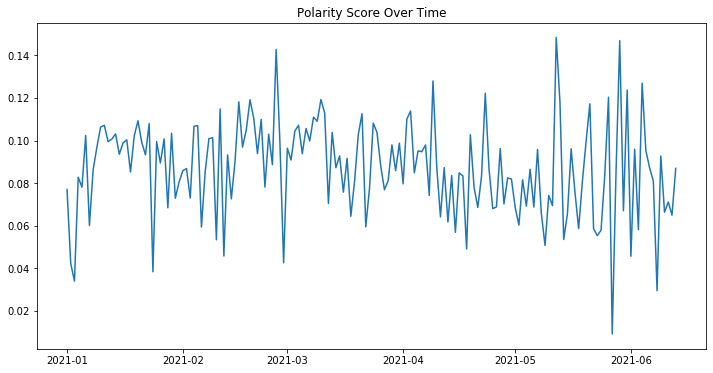

In [171]:
plt.figure(figsize=(12, 6))
plt.plot(sent_over_time)
plt.title("Polarity Score Over Time")

Overall, the trend looks pretty random with a few dramatic spikes, centered around a mean of ~0.08. Let's take a closer look at different locations. 

In [172]:
def sent_by_location(df, location):
    
    """
    creates time series of average polarity score 
    over time specific to each location passed in.
    """
    
    location_df = df[df['geo'] == location]
    location_df = location_df[['date', 'tb_polarity']].sort_values(by ='date').groupby('date').mean()
    location_df.index = pd.to_datetime(location_df.index)
    return location_df

In [173]:
hou_sent = sent_by_location(df, 'houston')
chi_sent = sent_by_location(df, 'chicago')
nyc_sent = sent_by_location(df, 'nyc')
la_sent = sent_by_location(df, 'la')

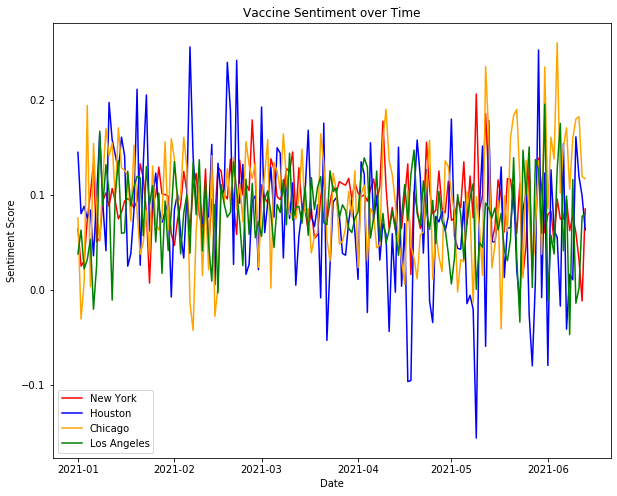

In [174]:
fig = plt.figure(figsize=(10, 8))
plt.plot(nyc_sent, label='New York', color='red')
plt.plot(hou_sent, label='Houston', color='blue')  
plt.plot(chi_sent, label='Chicago', color='orange')  
plt.plot(la_sent, label='Los Angeles', color='green')
plt.xlabel('Date')  
plt.ylabel('Sentiment Score') 
plt.title("Vaccine Sentiment over Time")  
plt.legend() 
# plt.savefig("Images/vaccine_sentiment")

In [175]:
print("NYC average polarity score: ", round(nyc_sent['tb_polarity'].mean(), 3))
print("Houston average polarity score: ", round(hou_sent['tb_polarity'].mean(),3))
print("Chicago average polarity score: ", round(chi_sent['tb_polarity'].mean(), 3))
print("Los Angeles average polarity score: ", round(la_sent['tb_polarity'].mean(), 3))

NYC average polarity score:  0.093
Houston average polarity score:  0.077
Chicago average polarity score:  0.092
Los Angeles average polarity score:  0.079


While all cities see a lot of fluctuation, NYC and Chicago have quite a high average showing that attitudes are very positive. NYC overall looks quite consistent, while in Chicago there are more dramatic highs and lows suggesting that opinion there is more polarized. 

Interestingly, LA and Houston have close averages. Houston we can see is the 'spikiest' of all with more dramatic swings in average whereas LA shows a bit more consistency. I'm going to export each of these so I can import them into my notebook of vaccine data, in order to conduct a correlation analysis.

In [176]:
#exporting these dataframes to use in my other notebook

# hou_sent.to_csv('data/houston_sentiment.csv')
# chi_sent.to_csv('data/chicago_sentiment.csv')
# nyc_sent.to_csv('data/nyc_sentiment.csv')
# la_sent.to_csv('data/la_sentiment.csv')

## Cluster Analysis

I'm using unsupervised learning techniques to do a clustering analysis to explore topics of conversation within my data. I'll look at positive vs negative vs neutral topics to see if there is any clear differentiation.

I'm using a Latent Dirichlet Allocation model, a probabilistic model that sees a document as a mix of topics, and a maps each word to a topic. 

This LDA model comes from Gensim and requires an input number of topics, as well a the body of text and a dictionary of word IDs and words.

### Positive Topics

In [177]:
# Create Dictionary
pos_id2word = corpora.Dictionary(processed_data_positive)
# Create Corpus
pos_texts = processed_data_positive
# Term Document Frequency
pos_corpus = [pos_id2word.doc2bow(text) for text in pos_texts]
# View the result
print(pos_corpus[:1][0][:10])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1)]


In [178]:
# Build LDA model
pos_lda_model = gensim.models.LdaMulticore(corpus=pos_corpus,
                                       id2word=pos_id2word,
                                       num_topics=3)
# Print the keywords in the topics
pprint(pos_lda_model.print_topics())
doc_lda = pos_lda_model[pos_corpus]

[(0,
  '0.021*"get" + 0.011*"covid" + 0.010*"people" + 0.008*"got" + 0.008*"first" '
  '+ 0.006*"im" + 0.006*"shot" + 0.006*"one" + 0.005*"dose" + 0.005*"like"'),
 (1,
  '0.012*"get" + 0.011*"first" + 0.011*"covid" + 0.006*"getting" + 0.006*"im" '
  '+ 0.005*"people" + 0.005*"day" + 0.005*"dose" + 0.005*"got" + '
  '0.004*"right"'),
 (2,
  '0.009*"people" + 0.009*"covid" + 0.008*"get" + 0.007*"got" + 0.006*"im" + '
  '0.006*"like" + 0.005*"getting" + 0.005*"dont" + 0.005*"first" + '
  '0.005*"would"')]


In [179]:
# Visualize the topics
pyLDAvis.enable_notebook()

In [180]:
pos_LDAvis_prepared = pyLDAvis.gensim.prepare(pos_lda_model, pos_corpus, pos_id2word)

In [181]:
with open('pos_LDAvis_prepared.pickle', 'wb') as f:
        pickle.dump(pos_LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open('pos_LDAvis_prepared.pickle', 'rb') as f:
    pos_LDAvis_prepared = pickle.load(f)

    # pyLDAvis.save_html(LDAvis_prepared)
pos_LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.006809 -0.045279  1       1        40.555694
2     -0.039071  0.028083  2       1        31.494463
1      0.045880  0.017196  3       1        27.949842, topic_info=             Term         Freq        Total Category  logprob  loglift
206   first        2269.000000  2269.000000  Default  30.0000  30.0000
80    get          4098.000000  4098.000000  Default  29.0000  29.0000
738   right        673.000000   673.000000   Default  28.0000  28.0000
2095  appointment  513.000000   513.000000   Default  27.0000  27.0000
449   day          806.000000   806.000000   Default  26.0000  26.0000
...   ...                 ...          ...       ...      ...      ...
311   need         210.431961   805.465154   Topic3  -5.9380  -0.0675 
204   everyone     193.817533   617.286742   Topic3  -6.0203   0.1163 
237   many         201.207670   741.564545   Topic3  -5.9828  -0.0297 
195   good         202.367664   905.952245   Topic3  -5.9771  -0.2241 
20    still        197.210198   902.435373   Topic3  -6.0029  -0.2461 

[305 rows x 6 columns], token_table=       Topic      Freq Term
term                       
12617  1      0.984992  12k
623    1      0.378114  2  
623    2      0.401433  2  
623    3      0.219872  2  
25612  2      0.878140  6+ 
...   ..           ... ..  
9115   1      0.067451  ž  
9115   2      0.876864  ž  
1053   1      0.369962  ”  
1053   2      0.539461  ”  
1053   3      0.091268  ”  

[550 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

### Negative Topics

In [182]:
neg_id2word = corpora.Dictionary(processed_data_negative)

neg_texts = processed_data_negative

neg_corpus = [neg_id2word.doc2bow(text) for text in neg_texts]

In [183]:
# Build LDA model
neg_lda_model = gensim.models.LdaMulticore(corpus=neg_corpus,
                                       id2word=neg_id2word,
                                       num_topics=3)
# Print the keywords in the topics
# pprint(lda_model.print_topics())
neg_doc_lda = neg_lda_model[neg_corpus]

In [184]:
neg_LDAvis_prepared = pyLDAvis.gensim.prepare(neg_lda_model, neg_corpus, neg_id2word)

In [185]:
with open('LDAvis_prepared.pickle', 'wb') as f:
        pickle.dump(neg_LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open('LDAvis_prepared.pickle', 'rb') as f:
    neg_LDAvis_prepared = pickle.load(f)

    # pyLDAvis.save_html(LDAvis_prepared)
neg_LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.032346  0.020903  1       1        39.322537
2      0.002759 -0.037236  2       1        31.954342
1     -0.035104  0.016334  3       1        28.723121, topic_info=        Term         Freq        Total Category  logprob  loglift
6    im       703.000000   703.000000   Default  30.0000  30.0000
1    get      1598.000000  1598.000000  Default  29.0000  29.0000
757  effects  157.000000   157.000000   Default  28.0000  28.0000
329  going    282.000000   282.000000   Default  27.0000  27.0000
107  people   1149.000000  1149.000000  Default  26.0000  26.0000
..      ...           ...          ...      ...      ...      ...
701  dont     100.585671   599.917722   Topic3  -5.8014  -0.5383 
719  want     81.646867    300.852338   Topic3  -6.0100  -0.0567 
213  shit     80.921433    295.131175   Topic3  -6.0190  -0.0465 
636  know     83.303923    355.288092   Topic3  -5.9899  -0.2030 
281  would    82.797195    357.092908   Topic3  -5.9960  -0.2141 

[290 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
13469  1      0.790779  13+     
517    1      0.408437  2       
517    2      0.222314  2       
517    3      0.372246  2       
2338   3      0.906230  2.3     
...   ..           ... ..       
14811  1      0.791573  ðÿš¨ðÿš¨
82     1      0.312724  ”       
82     2      0.422452  ”       
82     3      0.268833  ”       
13408  2      0.882215  ‡ðÿ¾ðÿ  

[501 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

## Conclusions

## Learnings and Recommendations